# Introduction

In this workshop, we will go through the steps of training and deploying a **network traffic classification model**.  We will show how to train two version of models where we will deploy them to a production and shadow variant.  We will use SageMaker Shadow Tests to help manage the test between the production and shadow variants.  

## Contents

1) [Setup](#setup)
2) [Basic Training](#basic_training)
3) [Register the Models](#register)
4) [Create Endpoint Config](#create_endpoint)
5) [Deploy and Predict](#deploy)
6) [Create a Shadow Test](#shadow)
7) [Evaluate](#eval)

For training our model we will be using datasets <a href="https://registry.opendata.aws/cse-cic-ids2018/">CSE-CIC-IDS2018</a> by CIC and ISCX which are used for security testing and malware prevention.
These datasets include a huge amount of raw network traffic logs, plus pre-processed data where network connections have been reconstructed and  relevant features have been extracted using CICFlowMeter, a tool that outputs network connection features as CSV files. Each record is classified as benign traffic, or it can be malicious traffic, with a total number of 15 classes.

Starting from this featurized dataset, we have executed additional pre-processing for the purpose of this lab:
<ul>
    <li>Encoded class labels</li>
    <li>Replaced invalid string attribute values generated by CICFlowMeter (e.g. inf and Infinity)</li>
    <li>Executed one hot encoding of discrete attributes</li>
    <li>Remove invalid headers logged multiple times in the same CSV file</li>
    <li>Reduced the size of the featurized dataset to ~1.3GB (from ~6.3GB) to speed-up training, while making sure that all classes are well represented</li>
    <li>Executed stratified random split of the dataset into training (80%) and validation (20%) sets</li>
</ul>

Class are represented and have been encoded as follows (train + validation):


| Label                    | Encoded | N. records |
|:-------------------------|:-------:|-----------:|
| Benign                   |    0    |    1000000 |
| Bot                      |    1    |     200000 |
| DoS attacks-GoldenEye    |    2    |      40000 |
| DoS attacks-Slowloris    |    3    |      10000 |
| DDoS attacks-LOIC-HTTP   |    4    |     300000 |
| Infilteration            |    5    |     150000 |
| DDOS attack-LOIC-UDP     |    6    |       1730 |
| DDOS attack-HOIC         |    7    |     300000 |
| Brute Force -Web         |    8    |        611 |
| Brute Force -XSS         |    9    |        230 |
| SQL Injection            |   10    |         87 |
| DoS attacks-SlowHTTPTest |   11    |     100000 |
| DoS attacks-Hulk         |   12    |     250000 |
| FTP-BruteForce           |   13    |     150000 |
| SSH-Bruteforce           |   14    |     150000 |       

The final pre-processed dataset has been saved to a public Amazon S3 bucket for your convenience, and will represent the inputs to the training processes.
<a id='setup'></a>
### Let's get started!

First, we set some variables, including the AWS region we are working in, the IAM (Identity and Access Management) execution role of the notebook instance and the Amazon S3 bucket where we will store data, models, outputs, etc. We will use the Amazon SageMaker default bucket for the selected AWS region, and then define a key prefix to make sure all objects have share the same prefix for easier discoverability.

In [1]:
%pip install jsonlines
%pip install sagemaker --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import glob
import json
import jsonlines
import base64

import boto3
import sagemaker
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.sklearn.estimator import SKLearn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output

pd.options.display.max_columns = 100

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()
prefix = 'xgboost-webtraffic'
os.environ["AWS_REGION"] = region

print(f'REGION:  {region}')
print(f'ROLE:    {role}')
print(f'BUCKET:  {bucket_name}')

# These are the clasifications that have been encoded as ints, we'll use these for analysis
class_list = ['Benign','Bot','DoS attacks-GoldenEye','DoS attacks-Slowloris','DDoS attacks-LOIC-HTTP','Infilteration','DDOS attack-LOIC-UDP','DDOS attack-HOIC','Brute Force-Web','Brute Force-XSS','SQL Injection','DoS attacks-SlowHTTPTest','DoS attacks-Hulk','FTP-BruteForce','SSH-Bruteforce']

REGION:  us-east-1
ROLE:    arn:aws:iam::462571479706:role/service-role/AmazonSageMaker-ExecutionRole-20221010T140438
BUCKET:  sagemaker-us-east-1-462571479706


#### Now we can copy the dataset from the public Amazon S3 bucket to the Amazon SageMaker default bucket used in this workshop. To do this, we will leverage on the AWS Python SDK (boto3) as follows:

In [3]:
s3 = boto3.resource('s3')

source_bucket_name = "endtoendmlapp"
source_bucket_prefix = "aim362/data/"
source_bucket = s3.Bucket(source_bucket_name)

for s3_object in source_bucket.objects.filter(Prefix=source_bucket_prefix):
    copy_source = {
        'Bucket': source_bucket_name,
        'Key': s3_object.key
    }
    print('Copying {0} ...'.format(s3_object.key))
    s3.Bucket(bucket_name).copy(copy_source, prefix+'/data/'+s3_object.key.split('/')[-2]+'/'+s3_object.key.split('/')[-1])
    
print(f'Data copy from source bucket, {source_bucket_name}/{source_bucket_prefix}, to destination bucket {bucket_name}/{prefix}/data/, complete!')

Copying aim362/data/train/0.part ...
Copying aim362/data/train/1.part ...
Copying aim362/data/train/2.part ...
Copying aim362/data/train/3.part ...
Copying aim362/data/train/4.part ...
Copying aim362/data/train/5.part ...
Copying aim362/data/train/6.part ...
Copying aim362/data/train/7.part ...
Copying aim362/data/train/8.part ...
Copying aim362/data/train/9.part ...
Copying aim362/data/val/0.part ...
Copying aim362/data/val/1.part ...
Copying aim362/data/val/2.part ...
Copying aim362/data/val/3.part ...
Copying aim362/data/val/4.part ...
Copying aim362/data/val/5.part ...
Copying aim362/data/val/6.part ...
Copying aim362/data/val/7.part ...
Copying aim362/data/val/8.part ...
Copying aim362/data/val/9.part ...
Data copy from source bucket, endtoendmlapp/aim362/data/, to destination bucket sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/, complete!


Let's download some of the data to the notebook to quickly explore the dataset structure:

# Data

In [4]:
train_file_path = 's3://' + bucket_name + '/' + prefix + '/data/train/0.part'
val_file_path = 's3://' + bucket_name + '/' + prefix + '/data/val/'

print(train_file_path)
print(val_file_path)

s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/train/0.part
s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/


In [5]:
!mkdir -p data/train/ data/val/
!aws s3 cp {train_file_path} data/train/ 
!aws s3 cp {val_file_path} data/val/ --recursive

download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/train/0.part to data/train/0.part
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/1.part to data/val/1.part
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/4.part to data/val/4.part
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/0.part to data/val/0.part
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/2.part to data/val/2.part
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/8.part to data/val/8.part
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/3.part to data/val/3.part
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/6.part to data/val/6.part
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/5.part to data/val/5.part
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/7.

In [6]:
df = pd.read_csv('data/train/0.part')
df

,Target,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,day,month,year,dayofweek,prot_0,prot_6,prot_17
0,0,445,64443,5,4,373,172,140,0,74.600000,70.283711,133,0,43.000000,62.753486,8457.086107,139.658303,8.055375e+03,1.105582e+04,21474,3,64403,1.610075e+04,1.073215e+04,21537,3,64398,2.146600e+04,129.201393,21547,21317,0,0,0,0,112,92,77.587946,62.070357,0,140,54.500000,64.198044,4121.388889,0,0,0,1,0,0,0,0,0.0,60.555556,74.600000,43.000000,0.0,0.0,0.0,0.0,0.0,0.0,5,373,4,172,8192,0,3,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0
1,12,80,1527,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,1309.757695,1.527000e+03,0.000000e+00,1527,1527,1527,1.527000e+03,0.000000e+00,1527,1527,0,0.000000e+00,0.000000,0,0,0,0,0,0,64,0,1309.757695,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,16,2,2018,4,0,1,0
2,7,80,5573,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,358.873138,5.573000e+03,0.000000e+00,5573,5573,5573,5.573000e+03,0.000000e+00,5573,5573,0,0.000000e+00,0.000000,0,0,0,0,0,0,40,0,358.873138,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,32738,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,21,2,2018,2,0,1,0
3,12,80,44934,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,44.509725,4.493400e+04,0.000000e+00,44934,44934,44934,4.493400e+04,0.000000e+00,44934,44934,0,0.000000e+00,0.000000,0,0,0,0,0,0,64,0,44.509725,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,16,2,2018,4,0,1,0
4,0,443,60108569,4,2,148,252,74,0,37.000000,42.723920,126,126,126.000000,0.000000,6.654625,0.099819,1.202171e+07,2.677679e+07,59921494,44882,60108569,2.003619e+07,3.454169e+07,59921494,93516,60013670,6.001367e+07,0.000000,60013670,60013670,1,0,0,0,80,40,0.066546,0.033273,0,126,67.714286,51.774235,2680.571429,0,1,0,0,1,0,0,0,0.0,79.000000,37.000000,126.000000,0.0,0.0,0.0,0.0,0.0,0.0,4,148,2,252,257,7010,1,20,93559.0,0.0,93559,93559,59921494.0,0.0,59921494,59921494,20,2,2018,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212208,14,22,298760,21,21,1912,2665,640,0,91.047619,139.679088,976,0,126.904762,263.574639,15319.989289,140.581068,7.286829e+03,2.230386e+04,122248,2,298722,1.493610e+04,3.049364e+04,122248,320,298752,1.493760e+04,33997.036726,126346,7,0,0,0,0,680,680,70.290534,70.290534,0,976,106.441860,207.291869,42969.919158,0,0,0,1,0,0,0,0,1.0,108.976190,91.047619,126.904762,0.0,0.0,0.0,0.0,0.0,0.0,21,1912,21,2665,26883,230,16,32,0.0,0.0,0,0,0.0,0.0,0,0,14,2,2018,2

In [7]:
%%time
val_csv_files = glob.glob("./data/val/*.part")
df_list = (pd.read_csv(file) for file in val_csv_files)
val_df= pd.concat(df_list, ignore_index=True)
val_df

CPU times: user 3.07 s, sys: 296 ms, total: 3.37 s
Wall time: 3.38 s


,Target,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,day,month,year,dayofweek,prot_0,prot_6,prot_17
0,14,22,7,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,285714.285714,7.000000e+00,0.000000e+00,7,7,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,32,32,142857.142857,142857.142857,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,1,0,0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,241,230,0,32,0.0,0.000000e+00,0,0,0.000000e+00,0.000000e+00,0,0,14,2,2018,2,0,1,0
1,0,443,110157200,15,19,855,351,844,0,57.000000,217.717379,117,0,18.473684,43.832216,10.947991,0.308650,3.338097e+06,4.609403e+06,10001371,1,110146216,7.867587e+06,3.756829e+06,10013825,64602,110145054,6.119170e+06,4.718583e+06,10012731,1,0,0,0,0,300,380,0.136169,0.172481,0,844,34.485714,144.689398,20935.021849,0,0,0,0,1,0,0,0,1.0,35.500000,57.000000,18.473684,0.0,0.0,0.0,0.0,0.0,0.0,15,855,19,351,63698,56222,11,20,471131.0,1.511692e+06,5028909,10963,9.542161e+06,1.487602e+06,10001371,5057294,22,2,2018,3,0,1,0
2,0,52615,853,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,2344.665885,8.530000e+02,0.000000e+00,853,853,853,8.530000e+02,0.000000e+00,853,853,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,2344.665885,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,14001,-1,0,20,0.0,0.000000e+00,0,0,0.000000e+00,0.000000e+00,0,0,3,2,2018,5,0,1,0
3,1,8080,11181,3,4,326,129,326,0,108.666667,188.216188,112,0,32.250000,53.767245,40694.034520,626.062070,1.863500e+03,4.053115e+03,10124,20,602,3.010000e+02,3.648671e+02,559,43,10642,3.547333e+03,5.700406e+03,10124,24,0,0,0,0,72,92,268.312315,357.749754,0,326,56.875000,115.406657,13318.696430,0,0,1,1,0,0,0,1,1.0,65.000000,108.666667,32.250000,0.0,0.0,0.0,0.0,0.0,0.0,3,326,4,129,8192,219,1,20,0.0,0.000000e+00,0,0,0.000000e+00,0.000000e+00,0,0,3,2,2018,5,0,1,0
4,12,80,52546,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,38.061889,5.254600e+04,0.000000e+00,52546,52546,52546,5.254600e+04,0.000000e+00,52546,52546,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,64,0,38.061889,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.000000e+00,0,0,0.000000e+00,0.000000e+00,0,0,16,2,2018,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530527,0,3389,2674228,8,7,1144,1581,677,0,143.000000,227.969923,1173,0,225.857143,430.098604,1018.985666,5.609095,1.910163e+05,2.190015e+05,822108,3,2674228,3.820326e+05,4.092434e+05,1275528,3,2428015,4.046692e+05,2.173301e+05,822108,247487,0,0,0,0,172,152,2.991518,2.617578,0,1173,170.312500,319.402717,10201

#### Here we set aside some data to evaluate our models once they're deployed

In [8]:
newval_df, holdout = train_test_split(val_df, test_size=.2, random_state=42, stratify=val_df['Target'])
print(holdout.shape)
print(newval_df.shape)

(106107, 85)
(424425, 85)


In [9]:
holdout.to_csv('./data/holdout.csv',index=False)
newval_df.to_csv('./data/val/newval.csv',index=False)
del val_df, newval_df

In [10]:
val_data_path = f"s3://{bucket_name}/{prefix}/data/val/newval.csv"
!aws s3 cp ./data/val/newval.csv {val_data_path}

upload: data/val/newval.csv to s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/data/val/newval.csv


<a id='basic_training'></a>
# Training

We will execute the training using the built in XGBoost algorithm.  Note that you can also use script mode if you need to have greater customization of the training process.  


In [11]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/data/train'.format(bucket_name, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/data/val/newval.csv'.format(bucket_name, prefix), content_type='csv')

## Model 1 - XGBoost

In [12]:
container = sagemaker.image_uris.retrieve('xgboost',region,version='1.0-1')
print(container)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


In [13]:
hyperparameters = {
    "max_depth": "3",
    "eta": "0.1",
    "gamma": "6",
    "min_child_weight": "6",
    "objective": "multi:softmax",
    "num_class": "15",
    "num_round": "10"
}

output_path = f's3://{bucket_name}/{prefix}/output/'

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=role,
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)



In [14]:
estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-02-03-17-55-40-777


2023-02-03 17:55:41 Starting - Starting the training job...
2023-02-03 17:55:57 Starting - Preparing the instances for training......
2023-02-03 17:56:46 Downloading - Downloading input data.....[2023-02-03 17:57:53.896 ip-10-2-74-201.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delim

## Model 2 - Sklearn Random Forest

In [15]:
output_path = f's3://{bucket_name}/{prefix}/output/'

FRAMEWORK_VERSION = "0.23-1"

estimator2 = SKLearn(
    entry_point="randomforest.py",
    source_dir='./code/',
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    metric_definitions=[
        {"Name": "Accuracy", "Regex": "Accuracy is: ([0-9.]+).*$"},
        {"Name": "WeightedF1", "Regex": "Weighted F1 Score is: ([0-9.]+).*$"}
    ],
    output_path=output_path,
    hyperparameters={
        "n-estimators": 50,
        "min-samples-leaf": 2
    }
)

In [16]:
estimator2.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: rf-scikit-2023-02-03-18-05-25-424


2023-02-03 18:05:25 Starting - Starting the training job......
2023-02-03 18:06:01 Starting - Preparing the instances for training...
2023-02-03 18:06:55 Downloading - Downloading input data......
2023-02-03 18:07:56 Training - Training image download completed. Training in progress..2023-02-03 18:07:57,109 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-02-03 18:07:57,112 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-03 18:07:57,149 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-02-03 18:07:57,300 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-03 18:07:57,311 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-03 18:07:57,322 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-03 18:07:57,332 sagemaker-training-toolkit INFO     Invoking user sc

#### Note the accuracy, F1 score, and classification report above.

#### In order to make sure that our code works for inference, we can deploy the trained model and execute some inferences.

<a id='register'></a>
## Register our models

In [17]:
sm_client = boto3.Session().client('sagemaker')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [18]:
model_name1 = "PROD-XGBoost-Webtraffic"
model_name2 = "SHADOW-RandomForest-Webtraffic"

print(f"Prod model name: {model_name1}")
print(f"Shadow model name: {model_name2}")

resp = sm_client.create_model(
    ModelName=model_name1,
    ExecutionRoleArn=role,
    PrimaryContainer={"Image": container, 
                      "ModelDataUrl": estimator.model_data
                     }
)

resp = sm_client.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    PrimaryContainer={
                      "Image": estimator2.training_image_uri(),
                      "Mode": "SingleModel",
                      "ModelDataUrl": estimator2.model_data,
                      "Environment": {
                          "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
                          "SAGEMAKER_SUBMIT_DIRECTORY":json.loads(estimator2.hyperparameters()['sagemaker_submit_directory']),
                          "SAGEMAKER_PROGRAM":json.loads(estimator2.hyperparameters()['sagemaker_program']),
                      },
                     }
)

Prod model name: PROD-XGBoost-Webtraffic
Shadow model name: SHADOW-RandomForest-Webtraffic


<a id='deploy'></a>
## Deploy!

Let's deploy the first model to a production real time SageMaker endpoint.  This is an HTTPS endpoint that is active 24 hours per day, 7 days per week.  It will stay active until we delete it.  Here we add a serializer to convert the incoming inference request to CSV.  We use a CSV serializer since the XGBoost Algorithm used in model 1 can accept data in 'text/libsvm' or 'text/csv' formats.  You can find additional details on the input/output interface in the [XGBoost Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html)

In [19]:
predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.2xlarge', serializer=sagemaker.serializers.CSVSerializer())

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-02-03-18-19-23-008
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-02-03-18-19-23-008
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-02-03-18-19-23-008


------!

In [20]:
predictor.endpoint_name

'sagemaker-xgboost-2023-02-03-18-19-23-008'

## Predict

#### Here we use the sagemaker predictor object to call our deployed instance. We send a set of hardcoded values that should result in an inference of 4, DDoS attacks-LOIC-HTTP, and that is the predicted value.

In [21]:
# single prediction
# We expect 4 - DDoS attacks-LOIC-HTTP as the predicted class.
test_values = [80,1056736,3,4,20,964,20,0,6.666666667,11.54700538,964,0,241.0,482.0,931.1691850999999,6.6241710320000005,176122.6667,431204.4454,1056315,2,394,197.0,275.77164469999997,392,2,1056733,352244.3333,609743.1115,1056315,24,0,0,0,0,72,92,2.8389304419999997,3.78524059,0,964,123.0,339.8873763,115523.4286,0,0,1,1,0,0,0,1,1.0,140.5714286,6.666666667,241.0,0.0,0.0,0.0,0.0,0.0,0.0,3,20,4,964,8192,211,1,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0]
result = predictor.predict(test_values)
print(result)

b'4.0'


<a id='shadow'></a>
# Create a Shadow Test 

## Create a Shadow Test using an Existing Endpoint

Now we will create a shadow test using the existing production endpoint.  We will pass the validation data we set aside earlier to the endpoint during this test and stop this test using the API later in the notebook.  Note that we could also specify the test start and stop time when we create the inference experiements.  If we don't provide the start and end times, then the experiment starts immediately and concludes after 7 days.  We are using an existing production endpoint for this test.  SageMaker will update that endpoint with the new model variants.  The production endpoint will also update the inference compute instance type for the production variant if needed. 


In [22]:
shadowtestname = 'ShadowInferenceTestExistingEP'
infexperimentarn = sm_client.create_inference_experiment(
    Name=shadowtestname,
    Type='ShadowMode',
    Description='Shadow inference test created via boto3 python API using an existing EP',
    RoleArn=role,
    EndpointName=predictor.endpoint_name,
    ModelVariants=[
        {
            'ModelName': model_name1,
            'VariantName': 'AllTraffic',
            'InfrastructureConfig': {
                'InfrastructureType':'RealTimeInference',
                'RealTimeInferenceConfig': {
                    'InstanceType': 'ml.m4.2xlarge',
                    'InstanceCount': 1 
                }
            }
        },
        
        {
            'ModelName': model_name2,
            'VariantName': 'Shadow-01',
            'InfrastructureConfig': {
                'InfrastructureType':'RealTimeInference',
                'RealTimeInferenceConfig': {
                    'InstanceType': 'ml.m4.2xlarge',
                    'InstanceCount': 1 
                }
            }
        },
    ],
    DataStorageConfig={
        'Destination':f's3://{bucket_name}/{prefix}/datacapture_test/',
    },
    ShadowModeConfig={
        'SourceModelVariantName': 'AllTraffic',
        'ShadowModelVariants': [
            {
                'ShadowModelVariantName': 'Shadow-01',
                'SamplingPercentage': 100
            },
        ]
    },
)   


In [23]:
shadowtestdescribe = sm_client.describe_inference_experiment(Name=shadowtestname)
shadowtestdescribe

{'Arn': 'arn:aws:sagemaker:us-east-1:462571479706:inference-experiment/shadowinferencetestexistingep',
 'Name': 'ShadowInferenceTestExistingEP',
 'Type': 'ShadowMode',
 'Schedule': {'StartTime': datetime.datetime(2023, 2, 3, 18, 27, 17, 254000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2023, 2, 10, 18, 22, 48, 743000, tzinfo=tzlocal())},
 'Status': 'Running',
 'Description': 'Shadow inference test created via boto3 python API using an existing EP',
 'CreationTime': datetime.datetime(2023, 2, 3, 18, 22, 44, 536000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 2, 3, 18, 27, 17, 254000, tzinfo=tzlocal()),
 'RoleArn': 'arn:aws:iam::462571479706:role/service-role/AmazonSageMaker-ExecutionRole-20221010T140438',
 'EndpointMetadata': {'EndpointName': 'sagemaker-xgboost-2023-02-03-18-19-23-008',
  'EndpointConfigName': 'ShadowInferenceT-EpConfig-jXjVrwlxLDWfEWSR',
  'EndpointStatus': 'InService'},
 'ModelVariants': [{'ModelName': 'PROD-XGBoost-Webtraffic',
   'Variant

TODO - Add comment about waiting for the experiement to be active.  Add code for a "waiter"

In [24]:
from time import sleep
def wait_until_test_complete(test_name):
    print(f'Waiting on shadow test: {test_name}')
    done = False
    while not done:
        shadowtestdescribe = sm_client.describe_inference_experiment(Name=shadowtestname)
        print("Status: " + shadowtestdescribe["Status"])
        if shadowtestdescribe["Status"].lower() == 'failed':
            print("Failure detected. Exiting Loop.")
            print(shadowtestdescribe)
            return
        elif shadowtestdescribe["Status"].lower() == 'running':
            print("Shadow test is running! Exiting Loop.")
            return
        sleep(60)

In [25]:
wait_until_test_complete(shadowtestname)

Waiting on shadow test: ShadowInferenceTestExistingEP
Status: Running
Shadow test is running! Exiting Loop.


## Simulate Production Traffic

We will now simulate the production traffic.  We will loop over the production data.  In a real production use case you won't need to do this since actual production data will be flowing to the production endpoint.  Since our shadow test is now active the production variant and the shadow variant will recieve the inference input.  Only the production output will be supplied in the response, however, since we have configured the test to capture data we will record both the production and shadow variant responses in s3.  


In [26]:
%%time  
# this should take ~ 13 minutes to complete
indexes = []
actuals = []
i = 0
for index, row in holdout.iterrows():
    vals = row.values
    prediction = predictor.predict(vals[1::],inference_id=f'shadow test, index {index}')
    actuals.append(vals[0])
    indexes.append(index)
    
    i+=1
    if i%10000 == 0:
        print(i)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
CPU times: user 2min 39s, sys: 5.84 s, total: 2min 44s
Wall time: 11min 56s


Since our Shadow test was running when we sent the data to our endpoint, we can get the test model's predictions from S3

In [27]:
storage = shadowtestdescribe['DataStorageConfig']['Destination']+predictor.endpoint_name +'/'
storage

's3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/datacapture_test/sagemaker-xgboost-2023-02-03-18-19-23-008/'

In [28]:
!aws s3 ls {storage}

                           PRE AllTraffic/
                           PRE Shadow-01/


#### Now let's copy the captured data from s3 to the local EFS connected to SageMaker Studio

In [29]:
!mkdir ./data/datacapture/

In [30]:
!aws s3 cp {storage} ./data/datacapture/  --recursive

download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/datacapture_test/sagemaker-xgboost-2023-02-03-18-19-23-008/AllTraffic/2023/02/03/18/29-24-564-ef72c707-3487-42f2-afe6-2e6895266225.jsonl to data/datacapture/AllTraffic/2023/02/03/18/29-24-564-ef72c707-3487-42f2-afe6-2e6895266225.jsonl
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/datacapture_test/sagemaker-xgboost-2023-02-03-18-19-23-008/AllTraffic/2023/02/03/18/31-24-574-dc66a634-c807-448c-98e5-594557e85458.jsonl to data/datacapture/AllTraffic/2023/02/03/18/31-24-574-dc66a634-c807-448c-98e5-594557e85458.jsonl
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/datacapture_test/sagemaker-xgboost-2023-02-03-18-19-23-008/AllTraffic/2023/02/03/18/30-24-567-297ee819-7e05-409c-b755-fedd1cce345a.jsonl to data/datacapture/AllTraffic/2023/02/03/18/30-24-567-297ee819-7e05-409c-b755-fedd1cce345a.jsonl
download: s3://sagemaker-us-east-1-462571479706/xgboost-webtraffic/datacapture_test/sagemaker-

##### The shadow and the production endpoints captured data during the test.  The data is saved in json lines format.  We also included an inference_id during the inference request.  We will use this information to match the inference data capture to the hold out dataset.  Our goal is to evaluate the performance of the production and shadow models we deployed to the endpoint.

In [31]:
shadowfiles = glob.glob('./data/datacapture/Shadow-01/**/*.jsonl',recursive=True)
prodfiles = glob.glob('./data/datacapture/AllTraffic/**/*.jsonl',recursive=True)

In [32]:
shadowin = []
shadowout = []
shadowid = []

for f in shadowfiles:
    print(f)
    with jsonlines.open(f) as reader:
        for obj in reader:
            
            try:
                infid = obj['eventMetadata']['inferenceId'].split(' ')
                shadowid.append(int(infid[-1]))

                # input to model
                model_input = base64.b64decode(obj['captureData']['endpointInput']['data']).decode('UTF-8').split(',')
                shadowin.append(model_input)

                # output from model
                model_output = base64.b64decode(obj['captureData']['endpointOutput']['data']).decode('UTF-8').strip('[').strip(']')
                shadowout.append(model_output)
            except:
                pass    
            
            
            

./data/datacapture/Shadow-01/2023/02/03/18/30-24-673-cce441c4-9dfb-4f48-ac00-d2689ec1beee.jsonl
./data/datacapture/Shadow-01/2023/02/03/18/38-25-085-09ebfafd-4c67-4f23-8248-0f5c2a5f223b.jsonl
./data/datacapture/Shadow-01/2023/02/03/18/28-24-548-72663202-618b-4046-9cbf-78ab37ecb3b6.jsonl
./data/datacapture/Shadow-01/2023/02/03/18/29-24-596-968471fd-efa7-4599-8110-0cf51da8d060.jsonl
./data/datacapture/Shadow-01/2023/02/03/18/36-24-989-ec022dd8-47e0-4dbb-bb8b-3c52b297d440.jsonl
./data/datacapture/Shadow-01/2023/02/03/18/34-24-823-698ca93a-1a6f-4dd4-98b3-da40306e18ca.jsonl
./data/datacapture/Shadow-01/2023/02/03/18/32-24-775-a6577270-9735-4f03-9e2d-bee5b364330f.jsonl
./data/datacapture/Shadow-01/2023/02/03/18/31-24-681-77e01521-90d9-4fef-b197-8a290ede8491.jsonl
./data/datacapture/Shadow-01/2023/02/03/18/35-24-912-5be0a334-b68d-4f14-9140-ca9c1b5c4a00.jsonl
./data/datacapture/Shadow-01/2023/02/03/18/33-24-801-70063851-a520-4dd6-b12b-39a7db166cc2.jsonl
./data/datacapture/Shadow-01/2023/02/03/

In [33]:
shadowdf = pd.DataFrame(data=shadowout,index=shadowid,columns=['Shadow'])

In [34]:
shadowdf['Shadow'] = shadowdf['Shadow'].astype(int)

In [35]:
shadowdf = pd.merge(shadowdf,holdout['Target'],left_index=True,right_index=True)

In [36]:
class_list

['Benign',
 'Bot',
 'DoS attacks-GoldenEye',
 'DoS attacks-Slowloris',
 'DDoS attacks-LOIC-HTTP',
 'Infilteration',
 'DDOS attack-LOIC-UDP',
 'DDOS attack-HOIC',
 'Brute Force-Web',
 'Brute Force-XSS',
 'SQL Injection',
 'DoS attacks-SlowHTTPTest',
 'DoS attacks-Hulk',
 'FTP-BruteForce',
 'SSH-Bruteforce']

In [37]:
acc = accuracy_score(shadowdf['Target'],shadowdf['Shadow'])
wf1 = f1_score(shadowdf['Target'],shadowdf['Shadow'],average='weighted')

In [38]:
print(classification_report(shadowdf['Target'],shadowdf['Shadow']))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4878
           1       1.00      1.00      1.00      1011
           2       1.00      1.00      1.00       197
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00      1428
           5       0.78      0.90      0.83       705
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00      1435
           8       1.00      0.75      0.86         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00       478
          12       1.00      1.00      1.00      1254
          13       1.00      1.00      1.00       689
          14       1.00      1.00      1.00       704

    accuracy                           0.98     12848
   macro avg       0.98      0.97      0.98     12848
weighted avg       0.98   

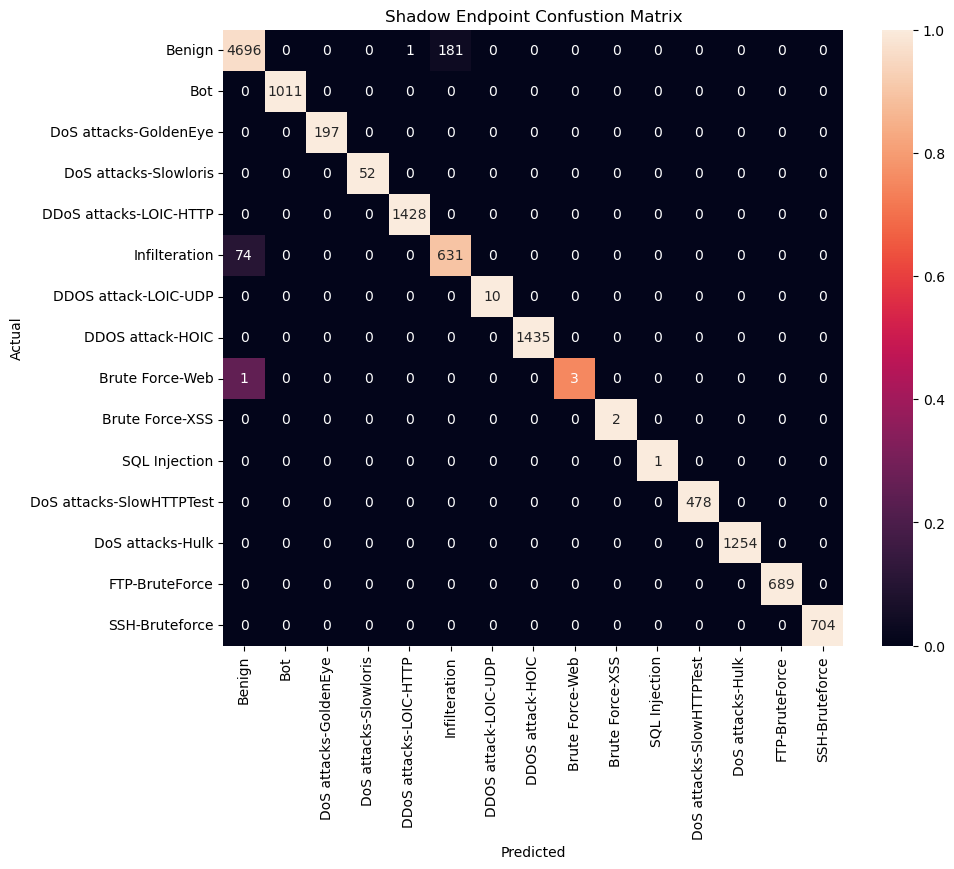

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(shadowdf['Target'],shadowdf['Shadow'])
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=class_list,yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Shadow Endpoint Confustion Matrix')
plt.show()

In [40]:
%%time

prodin = []
prodout = []
prodid = []

for f in prodfiles:
    print(f)
    with jsonlines.open(f) as reader:
        for obj in reader:
            try:
                infid = obj['eventMetadata']['inferenceId'].split(' ')
                prodid.append(int(infid[-1]))
                
                # input to model
                model_input = base64.b64decode(obj['captureData']['endpointInput']['data']).decode('UTF-8').split(',')
                prodin.append(model_input)

                # utput from model
                model_output = base64.b64decode(obj['captureData']['endpointOutput']['data']).decode('UTF-8').strip('[').strip(']')
                prodout.append(model_output)
                
            except:
                pass

./data/datacapture/AllTraffic/2023/02/03/18/31-24-574-dc66a634-c807-448c-98e5-594557e85458.jsonl
./data/datacapture/AllTraffic/2023/02/03/18/29-24-564-ef72c707-3487-42f2-afe6-2e6895266225.jsonl
./data/datacapture/AllTraffic/2023/02/03/18/37-24-598-a0cf143f-02b1-4a3d-990f-b1bc857bca70.jsonl
./data/datacapture/AllTraffic/2023/02/03/18/35-24-593-e8713733-b341-4c87-8afa-b38bdd706579.jsonl
./data/datacapture/AllTraffic/2023/02/03/18/30-24-567-297ee819-7e05-409c-b755-fedd1cce345a.jsonl
./data/datacapture/AllTraffic/2023/02/03/18/36-24-597-2c942197-0169-4df4-9bc2-1b753bc1e68f.jsonl
./data/datacapture/AllTraffic/2023/02/03/18/33-24-587-a4c5c14a-7aea-447c-8a18-2fa68634cbee.jsonl
./data/datacapture/AllTraffic/2023/02/03/18/39-24-601-ecd60cf9-befd-4df9-a4f3-7c17146187d2.jsonl
./data/datacapture/AllTraffic/2023/02/03/18/38-24-599-d5d03e30-977e-4390-8c7f-d9b919c5e44c.jsonl
./data/datacapture/AllTraffic/2023/02/03/18/28-24-557-e6e4b16b-f1c1-44b1-9e5d-5626b3f685ca.jsonl
./data/datacapture/AllTraffic/

In [46]:
proddf = pd.DataFrame(data=prodout,index=prodid,columns=['Prod'])
#proddf.dropna(inplace=True)

In [47]:
proddf['Prod'] = pd.to_numeric(proddf['Prod'])
proddf['Prod'] = proddf['Prod'].astype(int)

In [48]:
# Line up our production model predictions with the true value based on the index
proddf = pd.merge(proddf,holdout['Target'],left_index=True,right_index=True)

In [49]:
acc = accuracy_score(proddf['Target'],proddf['Prod'])
wf1 = f1_score(proddf['Target'],proddf['Prod'],average='weighted')

In [50]:
print(classification_report(proddf['Target'],proddf['Prod']))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     40000
           1       1.00      1.00      1.00      8000
           2       0.92      0.97      0.95      1600
           3       1.00      0.67      0.80       400
           4       0.98      1.00      0.99     12000
           5       0.78      0.73      0.75      6000
           6       1.00      1.00      1.00        69
           7       1.00      1.00      1.00     12000
           8       1.00      0.16      0.28        25
           9       1.00      0.78      0.88         9
          10       0.00      0.00      0.00         4
          11       1.00      1.00      1.00      4000
          12       1.00      1.00      1.00     10000
          13       1.00      1.00      1.00      6000
          14       1.00      1.00      1.00      6000

    accuracy                           0.97    106107
   macro avg       0.91      0.82      0.84    106107
weighted avg       0.97   

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

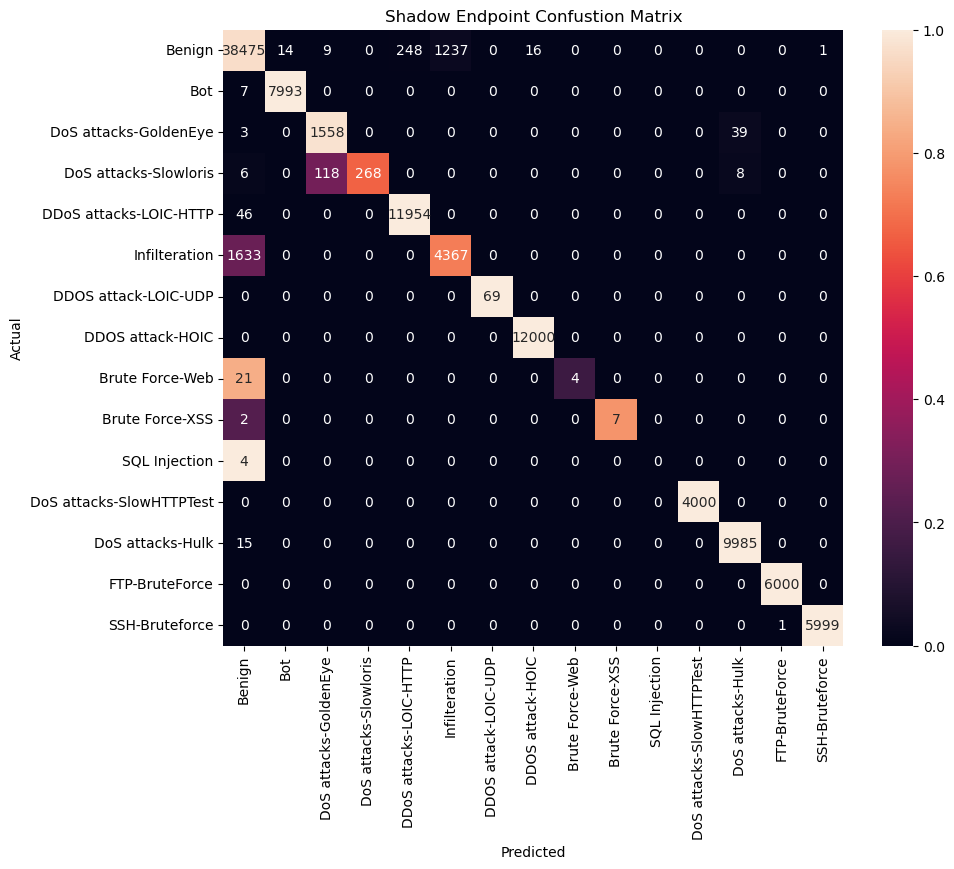

In [51]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(proddf['Target'],proddf['Prod'])
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=class_list,yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Shadow Endpoint Confustion Matrix')
plt.show()

##### We can see that our shadow model performs better on our validation data than the producion model, so let's promote the shadow to production.

In [54]:
sm_client.stop_inference_experiment(
    Name=shadowtestname,
    ModelVariantActions={
        'Shadow-01': 'Promote',
        'AllTraffic': 'Remove'
    },
    DesiredState='Completed',
    Reason='Variant performed better in validation'
)

{'InferenceExperimentArn': 'arn:aws:sagemaker:us-east-1:462571479706:inference-experiment/shadowinferencetestexistingep',
 'ResponseMetadata': {'RequestId': '11c0984b-9002-441d-a66f-7785f1de9e41',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '11c0984b-9002-441d-a66f-7785f1de9e41',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '120',
   'date': 'Fri, 03 Feb 2023 19:01:24 GMT'},
  'RetryAttempts': 0}}

##### If we discover problems after promoting our test model, we can easily roll back:

In [58]:
# Here we show that the shadow model is now deployed to production
sm_client.describe_endpoint(EndpointName = predictor.endpoint_name)

{'EndpointName': 'sagemaker-xgboost-2023-02-03-18-19-23-008',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:462571479706:endpoint/sagemaker-xgboost-2023-02-03-18-19-23-008',
 'EndpointConfigName': 'ShadowInferenceT-EpConfig-xxmdfgVjKIZMjdky',
 'ProductionVariants': [{'VariantName': 'Shadow-01',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn@sha256:5e8f763712da52ecf13e017632f4da10c6df9af626fa2c285ff38f90c34ede78',
     'ResolutionTime': datetime.datetime(2023, 2, 3, 19, 2, 12, 648000, tzinfo=tzlocal())}],
   'CurrentWeight': 100.0,
   'DesiredWeight': 100.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 2, 3, 18, 19, 23, 720000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 2, 3, 19, 5, 10, 66000, tzinfo=tzlocal())

##### Finally, let's gracefully stop the deployed endpoint.

## Clean Up

In [ ]:
#predictor.delete_endpoint()
sm_client.delete_inference_experiment(
    Name=shadowtestname
)

# References

* A Realistic Cyber Defense Dataset (CSE-CIC-IDS2018) - https://registry.opendata.aws/cse-cic-ids2018/
* AIM362 - Re:Invent 2019 SageMaker Debugger and Model Monitor - https://github.com/aws-samples/reinvent2019-aim362-sagemaker-debugger-model-monitor